In [ ]:
# main libs
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# additional libs
from itertools import product
import scipy.sparse as sp
from wordcloud import WordCloud

# processing and testing
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, accuracy_score, roc_auc_score

# models
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import ComplementNB, MultinomialNB, BernoulliNB
from sklearn.svm import SVC

# avoiding annoying warnings
import warnings

warnings.filterwarnings('ignore')

# Preprocessing

In [ ]:
df = pd.read_csv("articles_lemmatized_no_SW.csv", encoding="UTF-8")

In [ ]:
df = df.rename(mapper={"Unnamed: 0": "index"}, axis=1)
df.head()

,index,headline,body,topic
0,4069,Теперь подарки можно выбрать на сайте при помо...,поиск подарок любой праздник гораздо просто бл...,IT
1,1666,Тренды розничной торговли 2016,платформа соцсеть продолжать служить шопинг-пл...,IT
2,1802,Порталы сравнения цен вынуждают мелких ритейле...,последний время активно расти конкуренция обла...,IT
3,3784,9 беспроигрышных подарков для мужчины,каждый накануне февраль возникать сложный вопр...,IT
4,2186,Китайские производители сокращают свой бизнес ...,прекращать поставка новый автомобиль дилер рос...,Авто


In [ ]:
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 56499 entries, 0 to 56499
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   index     56499 non-null  int64 
 1   headline  56499 non-null  object
 2   body      56499 non-null  object
 3   topic     56499 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.2+ MB


Lets take a look on word cloud to make sure there are no stop-words \
(step for those who speak russian lmao)

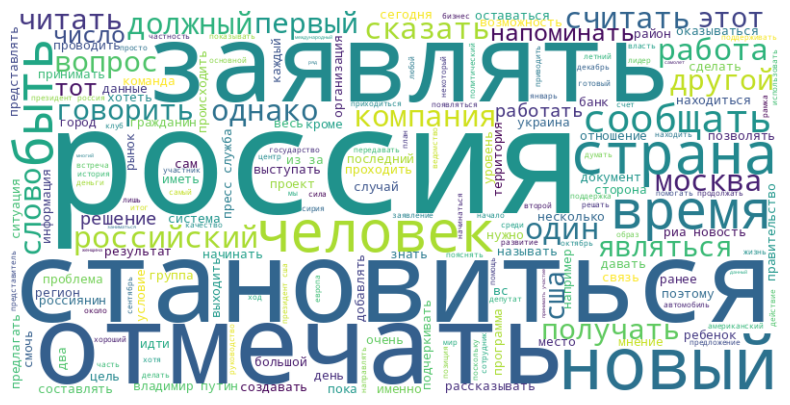

In [ ]:
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(df.sample(n=5000).body.sum())

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Now lets see set of topics we have

In [ ]:
uniques = df.topic.unique()
uniques

array(['IT', 'Авто', 'Армия', 'Выборы в США', 'Выборы-2016',
       'Гаджеты & Телеком', 'Деловая среда', 'День Победы',
       'День в истории', 'Знай наших', 'Известия: подробности',
       'Инновации', 'КНАУФ', 'Культура', 'Мир', 'Москва', 'Наука',
       'Недвижимость', 'Нефть и газ', 'Новости компаний', 'Образование',
       'Общество', 'ПМЭФ', 'Политика', 'Промышленность',
       'Путешествуем по России', 'РИО-2016', 'Россия - регионы', 'Спорт',
       'Страна', 'Технологическое предпринимательство', 'Транспорт',
       'Финансы', 'Формула лидерства', 'ЧЕ 2016', 'Шопинг', 'Экономика'],
      dtype=object)

Some of them have only a few articles so its not enough for analysis

In [ ]:
counts = df.topic.value_counts()
counts.to_numpy()

array([15131, 12147,  7359,  5280,  5032,  4881,  2635,  1295,   824,
         583,   449,   130,   118,   108,    96,    92,    63,    62,
          56,    38,    26,    17,    10,     9,     7,     6,     6,
           5,     5,     5,     5,     5,     4,     4,     2,     2,
           2])

We will delete those topics

In [ ]:
for topic in uniques:
  if counts[topic] <= 200:
    df = df[df.topic != topic]

Vectorize headlines and texts

In [ ]:
vectorizer = TfidfVectorizer()
X_h = vectorizer.fit_transform(df.headline)
X_b = vectorizer.fit_transform(df.body)

In [ ]:
X = sp.hstack((X_h, X_b), format='csr')
y = df.topic

Split vectors into test and train samples

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Check if all topics are contained in both test and train part

In [ ]:
print(len(y_train.unique()),
      len(y_test.unique()))

11 11


A function for visualization of results

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    Confusion matrix visualization

    parameters:
        cm - confusion matrix itself
        classes - list of classes' names (must correspond a shape of cm)
        normalize - if True, normalized matrix will be drawn
        title - plot title
        cmap - color map
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Naive Bayes Classifier

There are many variations of this algorithm, lets choose the best one for our case by testing

In [ ]:
def algs_comparison(X_train, y_train, names, models):

    results = []
    scoring = 'accuracy'
    for model in models:
        kfold = KFold(n_splits=10)
        cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
        results.append(cv_results)

    plt.figure(figsize=(9, 6))
    plt.title('Comparison of models on validation in 10 blocks: ')
    sns.set_style(style='whitegrid')
    initial = sns.boxplot(data=results, palette='Set1', notch=False)
    initial.set_xticklabels(names)
    plt.show()

Looks like complement NBC fits better here (at least in terms of `accuracy`)

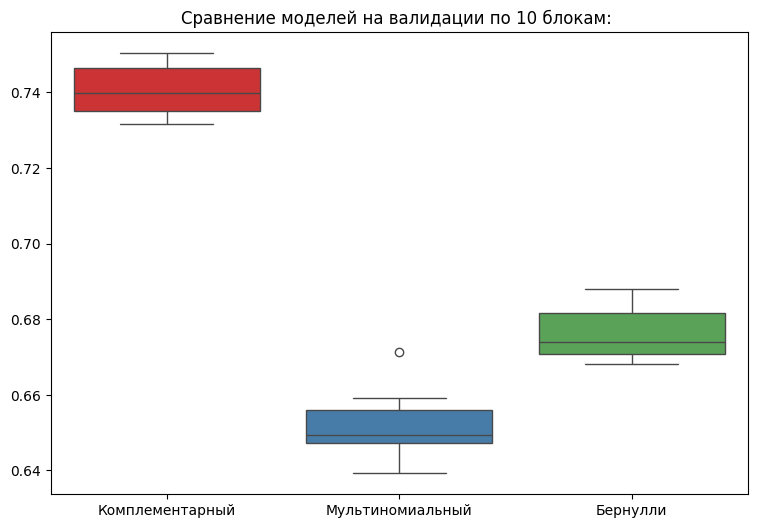

In [ ]:
algs_comparison(X_train,
                y_train,
                ["Complement", "Multinomial", "Bernoulli"],
                [ComplementNB(), MultinomialNB(), BernoulliNB()])

Lets see statistic numbers we got

In [ ]:
naive_bayes_classifier = ComplementNB()
naive_bayes_classifier.fit(X_train, y_train)

naive_bayes_pred = naive_bayes_classifier.predict(X_test)

In [ ]:
print(classification_report(y_test, naive_bayes_pred))

                   precision    recall  f1-score   support

            Армия       0.79      0.54      0.64       267
Гаджеты & Телеком       0.79      0.49      0.60       123
         Культура       0.73      0.93      0.82       536
              Мир       0.72      0.88      0.79      2999
            Наука       0.70      0.70      0.70       159
         Общество       0.71      0.72      0.72      2417
         Политика       0.73      0.32      0.44      1492
         РИО-2016       1.00      0.01      0.02        96
            Спорт       0.80      0.99      0.89       970
           Страна       0.87      0.64      0.74      1080
        Экономика       0.69      0.87      0.77       985

         accuracy                           0.74     11124
        macro avg       0.78      0.64      0.65     11124
     weighted avg       0.74      0.74      0.72     11124



Confusion matrix, without normalization


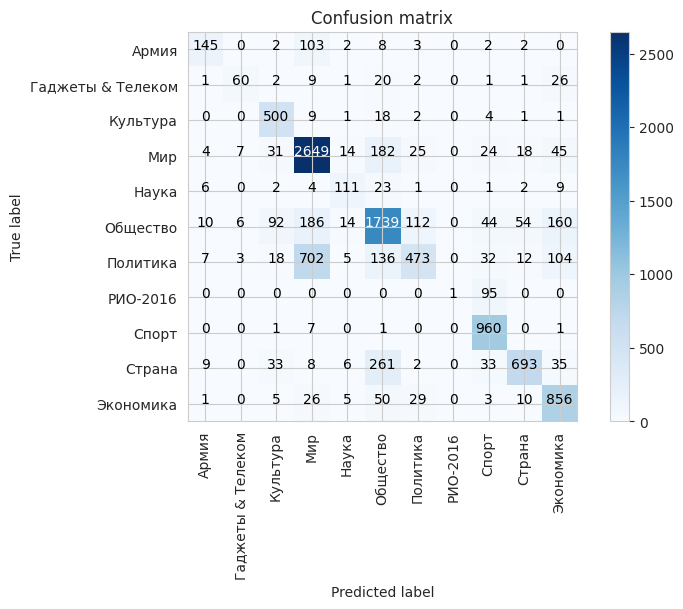

In [ ]:
cnf_matrix = confusion_matrix(y_test, naive_bayes_pred)
plt.figure(figsize=(8,6))
plot_confusion_matrix(cnf_matrix, classes=df.topic.unique(),
                      title='Confusion matrix')
plt.show()

# Random Forest Classifier

Need to select optimal hyperparameters set

In [ ]:
param_grid = {
       'n_estimators': [70, 100, 150, 200],
       'max_depth': [None, 10, 25],
       'min_samples_split': [2, 5]
}

clf = RandomForestClassifier()
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=3, scoring="accuracy")
grid_search.fit(X_train[:5000], y_train[:5000])

GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [None, 10, 25],
                         'min_samples_split': [2, 5],
                         'n_estimators': [70, 100, 150, 200]},
             scoring='accuracy')

In [ ]:
pd.DataFrame(grid_search.cv_results_) \
.drop(["params", "std_fit_time", "mean_score_time", "std_score_time", \
       "split0_test_score", "split1_test_score", "split2_test_score"], axis=1) \
.sort_values("rank_test_score") \
.head()

,mean_fit_time,param_max_depth,param_min_samples_split,param_n_estimators,mean_test_score,std_test_score,rank_test_score
2,40.267576,None,2,150,0.665601,0.004945,1
7,37.518826,None,5,200,0.665400,0.007981,2
3,52.541252,None,2,200,0.665199,0.006015,3
6,27.589224,None,5,150,0.662598,0.007678,4
5,18.783559,None,5,100,0.657802,0.005991,5


And use the one

In [ ]:
random_forest_classifier = RandomForestClassifier(n_estimators=150, min_samples_split=2, random_state=42)
random_forest_classifier.fit(X_train, y_train)

random_forest_pred = random_forest_classifier.predict(X_test)

In [ ]:
print(classification_report(y_test, random_forest_pred))

                   precision    recall  f1-score   support

            Армия       0.99      0.33      0.49       267
Гаджеты & Телеком       1.00      0.03      0.06       123
         Культура       0.90      0.77      0.83       536
              Мир       0.69      0.92      0.79      2999
            Наука       0.82      0.23      0.36       159
         Общество       0.68      0.78      0.73      2417
         Политика       0.72      0.42      0.53      1492
         РИО-2016       0.95      0.39      0.55        96
            Спорт       0.87      0.98      0.92       970
           Страна       0.96      0.71      0.82      1080
        Экономика       0.79      0.76      0.77       985

         accuracy                           0.75     11124
        macro avg       0.85      0.57      0.62     11124
     weighted avg       0.77      0.75      0.73     11124



Confusion matrix, without normalization


<Figure size 800x600 with 0 Axes>

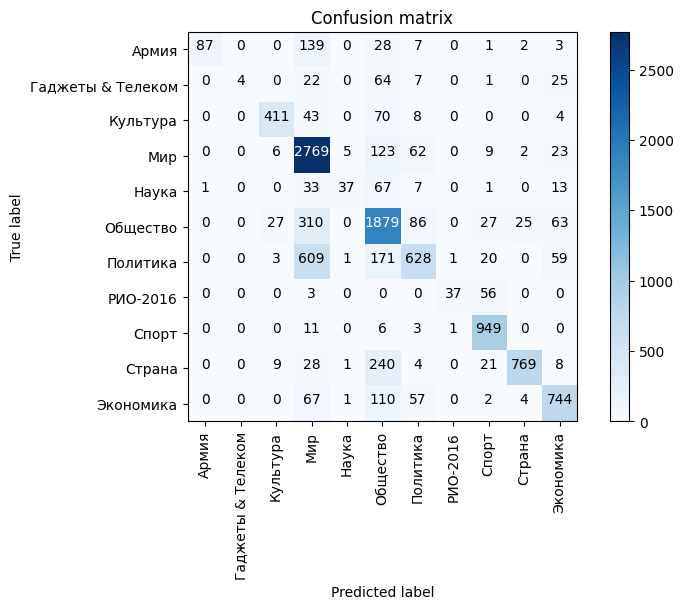

In [ ]:
cnf_matrix = confusion_matrix(y_test, random_forest_pred)
plt.figure(figsize=(8, 6))
plot_confusion_matrix(cnf_matrix, classes=df.topic.unique(),
                      title='Confusion matrix')
plt.show()

# Multilayer Perceptron Classifier

Also need to select optimal hyperparameters set

In [ ]:
param_grid = {
       'hidden_layer_sizes': [(200, 100), (100, 50), (50, 25)],
       'max_iter': [100, 200, 500],
       'learning_rate_init': [0.001, 0.01]
}

clf = MLPClassifier()
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=3, scoring="accuracy")
grid_search.fit(X_train[:1000], y_train[:1000])

GridSearchCV(cv=3, estimator=MLPClassifier(),
             param_grid={'hidden_layer_sizes': [(200, 100), (100, 50),
                                                (50, 25)],
                         'learning_rate_init': [0.001, 0.01],
                         'max_iter': [100, 200, 500]},
             scoring='accuracy')

In [ ]:
pd.DataFrame(grid_search.cv_results_) \
.drop(["params", "std_fit_time", "mean_score_time", "std_score_time", \
       "split0_test_score", "split1_test_score", "split2_test_score"], axis=1) \
.sort_values("rank_test_score") \
.head()

,mean_fit_time,param_hidden_layer_sizes,param_learning_rate_init,param_max_iter,mean_test_score,std_test_score,rank_test_score
1,325.403845,"(200, 100)",0.001,200,0.667029,0.022925,1
2,335.846293,"(200, 100)",0.001,500,0.662027,0.019457,2
15,46.003332,"(50, 25)",0.010,100,0.656042,0.030115,3
9,71.049344,"(100, 50)",0.010,100,0.654043,0.036341,4
7,252.987147,"(100, 50)",0.001,200,0.654031,0.024193,5


And use the one

In [ ]:
multilayer_perceptron_classifier = MLPClassifier(hidden_layer_sizes=(50, 25),
                    max_iter=100,
                    learning_rate_init=0.01,
                    random_state=42)
multilayer_perceptron_classifier.fit(X_train, y_train)

multilayer_perceptron_pred = multilayer_perceptron_classifier.predict(X_test)

In [ ]:
print(classification_report(y_test, multilayer_perceptron_pred))

                   precision    recall  f1-score   support

            Армия       0.75      0.62      0.68       267
Гаджеты & Телеком       0.63      0.54      0.58       123
         Культура       0.84      0.80      0.82       536
              Мир       0.79      0.80      0.79      2999
            Наука       0.64      0.53      0.58       159
         Общество       0.69      0.79      0.74      2417
         Политика       0.60      0.53      0.56      1492
         РИО-2016       0.78      0.76      0.77        96
            Спорт       0.93      0.92      0.92       970
           Страна       0.89      0.83      0.86      1080
        Экономика       0.79      0.75      0.77       985

         accuracy                           0.76     11124
        macro avg       0.76      0.72      0.73     11124
     weighted avg       0.76      0.76      0.76     11124



Confusion matrix, without normalization


<Figure size 800x600 with 0 Axes>

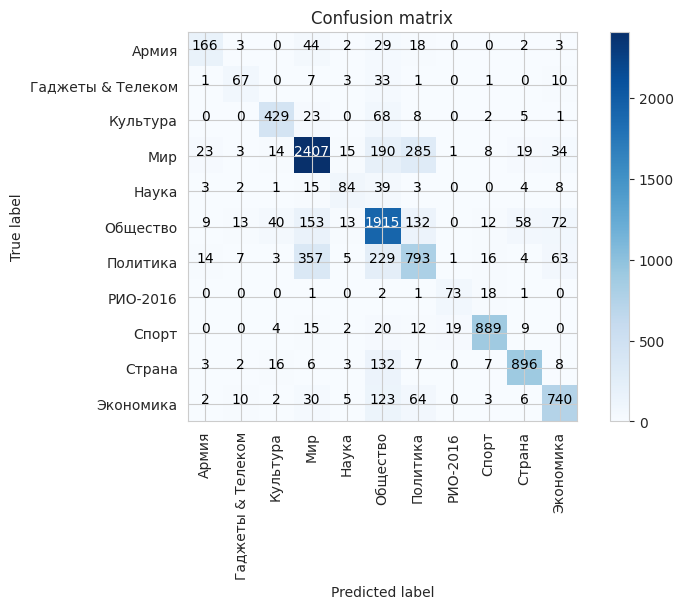

In [ ]:
cnf_matrix = confusion_matrix(y_test, multilayer_perceptron_pred)
plt.figure(figsize=(8, 6))
plot_confusion_matrix(cnf_matrix, classes=df.topic.unique(),
                      title='Confusion matrix')
plt.show()

# Support vector Classifier

The same process again

In [ ]:
param_grid = {
         'C': [1, 5, 10],
         'max_iter': [-1, 100],
         'class_weight': [None, 'balanced']
     }

clf = SVC()
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=3, scoring='accuracy')
grid_search.fit(X_train[:5000], y_train[:5000])

GridSearchCV(cv=3, estimator=SVC(),
             param_grid={'C': [1, 5, 10], 'class_weight': [None, 'balanced'],
                         'max_iter': [-1, 100]},
             scoring='accuracy')

In [ ]:
pd.DataFrame(grid_search.cv_results_) \
.drop(["params", "std_fit_time", "mean_score_time", "std_score_time", \
       "split0_test_score", "split1_test_score", "split2_test_score"], axis=1) \
.sort_values("rank_test_score") \
.head()

,mean_fit_time,param_C,param_class_weight,param_max_iter,mean_test_score,std_test_score,rank_test_score
4,34.178356,5,None,-1,0.664202,0.007085,1
8,34.046277,10,None,-1,0.664202,0.007085,1
10,34.037727,10,balanced,-1,0.664202,0.007085,1
6,34.141795,5,balanced,-1,0.664002,0.007311,4
5,7.436959,5,None,100,0.653803,0.011571,5


In [ ]:
support_vector_classifier = SVC(C=10, class_weight='balanced')
support_vector_classifier.fit(X_train, y_train)

support_vector_pred = support_vector_classifier.predict(X_test)

In [ ]:
print(classification_report(y_test, support_vector_pred))

                   precision    recall  f1-score   support

            Армия       0.79      0.69      0.74       267
Гаджеты & Телеком       0.75      0.55      0.64       123
         Культура       0.85      0.85      0.85       536
              Мир       0.80      0.89      0.84      2999
            Наука       0.68      0.62      0.64       159
         Общество       0.75      0.81      0.78      2417
         Политика       0.72      0.53      0.61      1492
         РИО-2016       0.86      0.62      0.72        96
            Спорт       0.90      0.96      0.93       970
           Страна       0.96      0.85      0.90      1080
        Экономика       0.79      0.79      0.79       985

         accuracy                           0.80     11124
        macro avg       0.80      0.74      0.77     11124
     weighted avg       0.80      0.80      0.80     11124



Confusion matrix, without normalization


<Figure size 800x600 with 0 Axes>

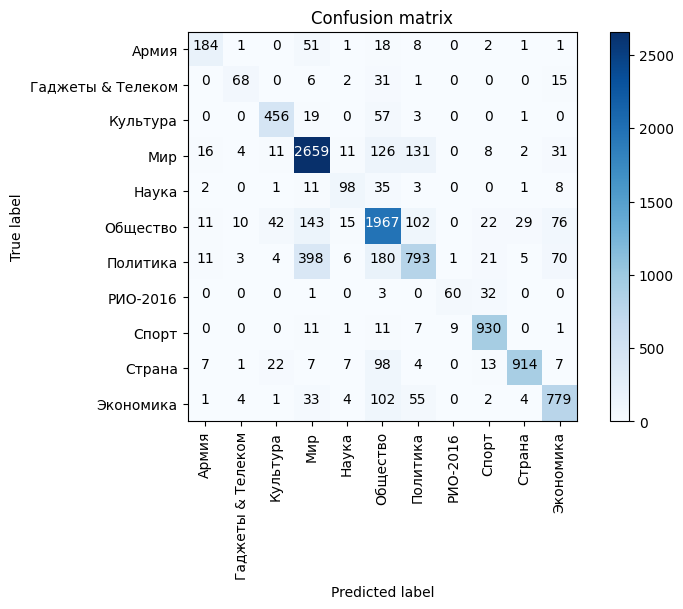

In [ ]:
cnf_matrix = confusion_matrix(y_test, support_vector_pred)
plt.figure(figsize=(8, 6))
plot_confusion_matrix(cnf_matrix, classes=df.topic.unique(),
                      title='Confusion matrix')
plt.show()

# Results & conclusions

Lets now make a table with all main results we got for different models

In [ ]:
preds = [naive_bayes_pred, random_forest_pred, multilayer_perceptron_pred, support_vector_pred]

In [ ]:
results = pd.DataFrame(
    {
        'model': ['NBC', 'RFC', 'MPC', 'SVC'],
        'precision': [round(precision_score(y_test, pred, average='weighted'), 4) for pred in preds],
        'recall': [round(recall_score(y_test, pred, average='weighted'), 4) for pred in preds],
        'accuracy': [round(accuracy_score(y_test, pred), 4) for pred in preds],
    }
)

results

,model,precision,recall,accuracy
0,NBC,0.7430,0.7360,0.7360
1,RFC,0.7673,0.7474,0.7474
2,MPC,0.7611,0.7604,0.7604
3,SVC,0.7999,0.8008,0.8008


1. Why did the models show such poor accuracy?
There is a simple explanation for this: firstly, the dataset contains articles that even a person can often classify into several topics at the same time. An example is news from the sections *World (Мир), Society (Общество) and
Politics (Политика)* . This is clearly visible in the confusion matrices. Secondly, the dataset is not balanced in terms of the number of news items for each topic, and therefore, during testing, the models can hardly distinguish rare articles from others. This conclusion can be drawn from the difference in the average and average-weighted indicators in the classification reports.

2. What metric should be used to evaluate the efficiency of algorithms? The most common (and, in my opinion, quite applicable in this case) metric for classification among those presented is the proportion of correct answers (`accuracy`). When maximizing it, a good balance is achieved between `precision` and `recall`. We selected the parameters of the models based on the proportion of correct answers, and I suggest to make a verdict based on it.

3. Which algorithm performed the best? The results table shows that the **support vector method** is in the lead in terms of the proportion of correct answers. It is worth noting that its training took the longest; compared to the naive Bayes method, this process was thousands of times slower. However, the problem does not imply any requirements for the speed of training, which means that this should not be considered a major drawback.